In [58]:
import os
import cv2
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from models import SimplifiedConvNet
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [59]:
import torch
import numpy as np
import os

def load_data_from_file(file_path):
    data_label_pairs = np.load(file_path, allow_pickle=True)
    processed_data = []
    labels = []

    for data_item, label in data_label_pairs:
        # Convert numpy array to torch tensor and ensure it's float type
        image = torch.from_numpy(data_item).float()

        # Check the shape and permute if necessary
        if image.shape == (128, 128, 2):
            image = image.permute(2, 0, 1)

        processed_data.append(image)
        labels.append(label)

    return processed_data, labels

def load_data(directory_path):
    all_data = []
    all_labels = []
    for filename in os.listdir(directory_path):
        if filename.endswith('.npy'):
            file_path = os.path.join(directory_path, filename)
            data, labels = load_data_from_file(file_path)
            all_data.extend(data)
            all_labels.extend(labels)
    return torch.stack(all_data), torch.tensor(all_labels)

# Define the file directories
train_data_dir = '/Users/gbutts/Desktop/datasets/train_data'
test_data_dir = '/Users/gbutts/Desktop/datasets/test_data'

# Load the data
train_data, train_label = load_data(train_data_dir)
test_data, test_label = load_data(test_data_dir)

In [60]:
mean = train_data.mean()
std = train_data.std()

In [61]:
directory = "/Users/gbutts/Desktop/QuinnLetters"

net = SimplifiedConvNet()

model_path = 'convnet_weights.pth'
net.load_state_dict(torch.load(model_path))
net.eval()

SimplifiedConvNet(
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (dropout4): Dropout(p=0.5

In [92]:
def apply_fft_and_inverse(im):
    """Apply FFT and inverse FFT on an image."""
    f_transform = np.fft.fft2(im)
    f_shift = np.fft.fftshift(f_transform)
    rows, cols = im.shape
    crow, ccol = rows // 2, cols // 2
    high_pass_filter_radius = 3
    f_shift[crow - high_pass_filter_radius:crow + high_pass_filter_radius,
            ccol - high_pass_filter_radius:ccol + high_pass_filter_radius] = 0
    f_ishift = np.fft.ifftshift(f_shift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

In [105]:
def get_char(tensor):
    
    #print(tensor)
    max_index = torch.argmax(tensor, dim=1)

    keys = ['0', '1', '2', '3', '4', '5', '6', 
            '7', '8', '9', 'A', 'B', 'C', 'D', 
            'E', 'F', 'G', 'H', 'I', 'J', 'K',
            'L', 'M', 'N', 'O', 'P', 'Q', 'R',
            'R', 'S', 'T', 'U', 'V', 'W', 'X',
            'Y', 'Z', 'a', 'b', 'c', 'e', 'f',
            'g', 'h', 'i', 'j', 'k', 'l', 'm',
            'n', 'o', 'p', 'q', 'r', 's', 't',
            'u', 'v', 'w', 'x', 'y', 'z']

    # Get the character corresponding to the index
    character = keys[max_index.item()]

    return character

In [106]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

def process_and_predict(image_path, net, mean, std):
    # Read and preprocess the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Display the original image
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.show()

    # Resize the image
    image_resized = cv2.resize(image, (128, 128))

    # Display the resized image
#     plt.imshow(image_resized, cmap='gray')
#     plt.title("Resized Image")
#     plt.show()

    # Convert to numpy array
    image_array = np.array(image_resized)

    # Apply FFT and inverse FFT
    processed_image = apply_fft_and_inverse(image_array)

    # Display the processed image
#     plt.imshow(processed_image, cmap='gray')
#     plt.title("Processed Image")
#     plt.show()

    # Stack the original and processed images
    stacked_image = np.stack((image_array, processed_image), axis=0)

    # Display the stacked image (showing only the first channel)
#     plt.imshow(stacked_image[0, :, :], cmap='gray')
#     plt.title("Stacked Image - Channel 1")
#     plt.show()

    # Adjust the dimensions of the stacked image
    stacked_image = np.expand_dims(stacked_image, axis=0)

    # Normalize the tensor
    tensor_image = (torch.tensor(stacked_image, dtype=torch.float32) - mean) / std

    # Make a prediction
    prediction = net(tensor_image)

    return prediction


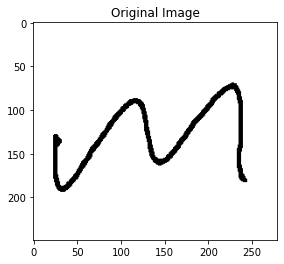

Prediction for m_lower.png: M


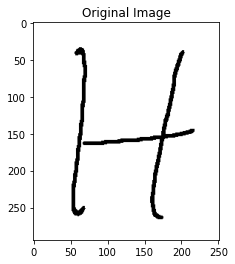

Prediction for H.png: H


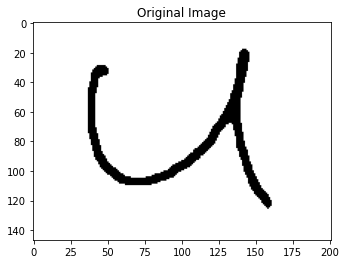

Prediction for u_lower.png: 4


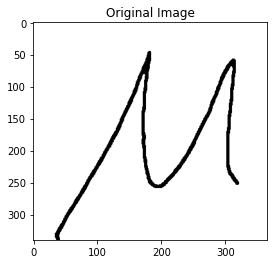

Prediction for M.png: M


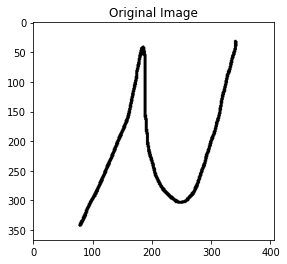

Prediction for N.png: N


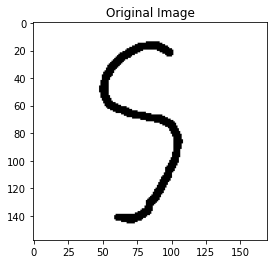

Prediction for s_lower.png: 5


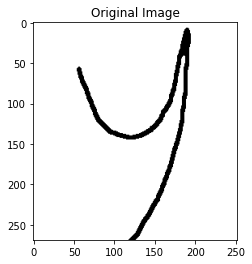

Prediction for y_lower.png: 4


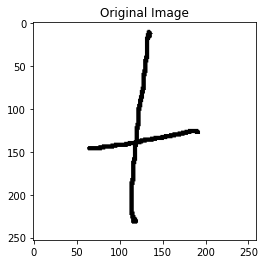

Prediction for t_lower.png: t


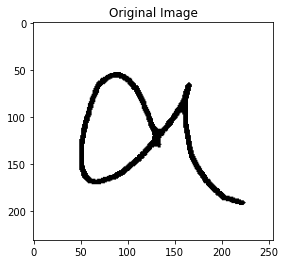

Prediction for a_lower.png: a


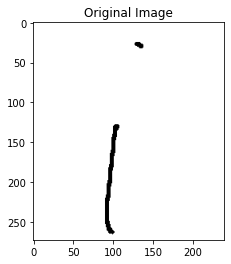

Prediction for i_lower.png: i


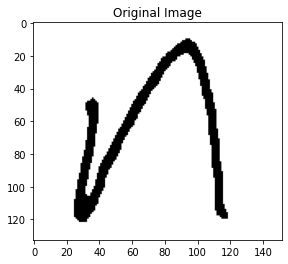

Prediction for n_lower.png: n


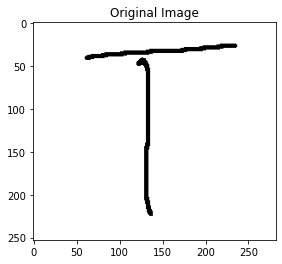

Prediction for T.png: T


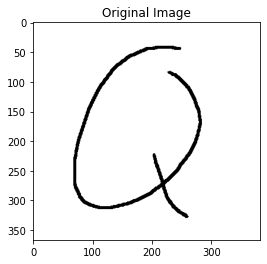

Prediction for Q.png: Q


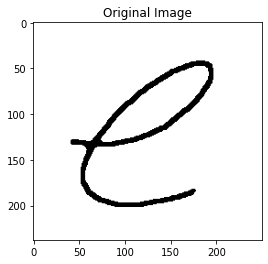

Prediction for e_lower.png: e


In [107]:
for filename in os.listdir(directory):
    if filename.endswith(".png"):  # Assuming images are in JPG format
        file_path = os.path.join(directory, filename)
        prediction = process_and_predict(file_path, net, mean, std)
        char = get_char(prediction)
        print(f"Prediction for {filename}: {char}")